# Unraveling Gravitational Ripples: Neural Network Classification

### GASF vs FFT with New Data

### GWGASF Members: Daniel Fredin, Cole Welch, & Arif Chu

--------------------

In [1]:
%matplotlib inline

import numpy as np
import h5py 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler

from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField

from scipy import signal
from gwpy.timeseries import TimeSeries

from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Initializes numpy and pytorch random seeds for reproducibility 
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Prepare Data

# GASF
#### Retreive Dataset For GASF

In [2]:
### -------------Load dataset------------- ###

# Define the file name
filename = 'classify_data.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bbh_train = np.array(file['Training']['bbh'])
    bbh_val = np.array(file['Validation']['bbh'])
    glitch_train = np.array(file['Training']['glitch'])
    glitch_val = np.array(file['Validation']['glitch'])

In [3]:
### -------------Label our data as background or signal------------- ###

# Allows us to easily apply labels to our data to denote it as signal or background for classification.
anomaly_class = {
    'Glitch': 0,
    'Signal': 1
}

# ID our data as background or signal.
glitch_train_ids = np.full(glitch_train.shape[0], anomaly_class['Glitch'], dtype=int)
glitch_val_ids = np.full(glitch_val.shape[0], anomaly_class['Glitch'], dtype=int)

bbh_train_ids = np.full(bbh_train.shape[0], anomaly_class['Signal'], dtype=int)
bbh_val_ids = np.full(bbh_val.shape[0], anomaly_class['Signal'], dtype=int)

In [4]:
### -------------Merge dataset------------- ###

# Stick our background and signal data together for training and testing.
x_train = np.concatenate((glitch_train, bbh_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)

x_val_data = np.concatenate((glitch_val, bbh_val), axis=0).transpose((0,2,1))
y_val = np.concatenate((glitch_val_ids, bbh_val_ids), axis=0)

In [5]:
### -------------Shuffle dataset------------- ###

# Shuffle the training data using a randomly chosen permutation. This ensures we don't encounter artifacts from background 
# and signal data being clumped together.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

#### Convert Data to Images

#### Cleanup and extract signal

In [6]:
### -------------Split detector dataset------------- ###

# Each 2D dataset of gravitational wave data comes from one of two detectors: 1 (located in Hanford, WA) and 2 
# (located in Livingston, LA). Split the data from these two detectors since we can only pass 2D images into our CNN to train.
x_train_dec1_raw = x_train[:,:,0]
x_train_dec2_raw = x_train[:,:,1]

x_val_dec1_raw = x_val_data[:,:,0]
x_val_dec2_raw = x_val_data[:,:,1]

In [7]:
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
import numpy as np

# Bandpass filter for 50hz and 250hz
bp = filter_design.bandpass(50, 250, 4096)

## First three harmonics of the 60 Hz AC mains power:
notches = [filter_design.notch(line, 4096) for line in (60, 120, 180)]
zpk = filter_design.concatenate_zpks(bp, *notches)

# Function to process a single item
def process_data(raw_data):
    hdata = TimeSeries(raw_data)
    hdata = hdata.whiten() 
    hdata = hdata.crop(*hdata.span.contract(1)) # The whitened timeseries data

    hfilt = hdata.filter(zpk, filtfilt=True)
    hfilt = hfilt.crop(*hfilt.span.contract(1)) # The filtered and whitened timeseries data

    return hfilt, hdata


# Process training data
x_train_dec1_data_arr = []
x_train_dec1_filt_arr = []
x_train_dec2_data_arr = []
x_train_dec2_filt_arr = []
x_val_dec1_data_arr = []
x_val_dec1_filt_arr = []
x_val_dec2_data_arr = []
x_val_dec2_filt_arr = []


for raw_data in x_train_dec1_raw:
    hdata, hfilt = process_data(raw_data)
    x_train_dec1_data_arr.append(hdata)
    x_train_dec1_filt_arr.append(hfilt)

x_train_dec1_data_arr = np.array(x_train_dec1_data_arr)
x_train_dec1_filt_arr = np.array(x_train_dec1_filt_arr)


for raw_data in x_train_dec2_raw:
    hdata, hfilt = process_data(raw_data)
    x_train_dec2_data_arr.append(hdata)
    x_train_dec2_filt_arr.append(hfilt)

x_train_dec2_data_arr = np.array(x_train_dec2_data_arr)
x_train_dec2_filt_arr = np.array(x_train_dec2_filt_arr)


for raw_data in x_val_dec1_raw:
    hdata, hfilt = process_data(raw_data)
    x_val_dec1_data_arr.append(hdata)
    x_val_dec1_filt_arr.append(hfilt)

x_val_dec1_data_arr = np.array(x_val_dec1_data_arr)
x_val_dec1_filt_arr = np.array(x_val_dec1_filt_arr)


for raw_data in x_val_dec2_raw:
    hdata, hfilt = process_data(raw_data)
    x_val_dec2_data_arr.append(hdata)
    x_val_dec2_filt_arr.append(hfilt)

x_val_dec2_data_arr = np.array(x_val_dec2_data_arr)
x_val_dec2_filt_arr = np.array(x_val_dec2_filt_arr)



In [8]:
x_train_dec1 = x_train_dec1_filt_arr
x_train_dec2 = x_train_dec2_filt_arr
x_val_dec1 = x_val_dec1_filt_arr
x_val_dec2 = x_val_dec2_filt_arr

In [9]:
# from gwpy.timeseries import TimeSeries
# from gwpy.signal import filter_design

# bp = filter_design.bandpass(50, 250, 4096)

# notches = [filter_design.notch(line, 4096) for
#            line in (60, 120, 180)]

# zpk = filter_design.concatenate_zpks(bp, *notches)



# ## NOTE: make a hdata_RAW list and maybe create variables for raw data and time series data.




# hdata_list = []
# hfilt_list = []
# for i in range(len(x_train_dec1_raw)):
#     hdata = TimeSeries(x_train_dec1_raw[i])
#     hdata = hdata.whiten()
#     hdata = hdata.crop(*hdata.span.contract(1))
#     hdata_list.append(hdata)

#     hfilt = hdata.filter(zpk, filtfilt=True)
#     hfilt = hfilt.crop(*hfilt.span.contract(1))
#     hfilt_list.append(hfilt)

# x_train_dec1_filt_arr = np.array(hfilt_list)
# x_train_dec1_data_arr = np.array(hdata_list)




# hdata_list = []
# hfilt_list = []
# for i in range(len(x_train_dec2_raw)):
#     hdata = TimeSeries(x_train_dec2_raw[i])
#     hdata = hdata.whiten()
#     hdata = hdata.crop(*hdata.span.contract(1))
#     hdata_list.append(hdata)

#     hfilt = hdata.filter(zpk, filtfilt=True)
#     hfilt = hfilt.crop(*hfilt.span.contract(1))
#     hfilt_list.append(hfilt)

# x_train_dec2_filt_arr = np.array(hfilt_list)
# x_train_dec2_data_arr = np.array(hdata_list)





# hdata_list = []
# hfilt_list = []
# for i in range(len(x_val_dec1_raw)):
#     hdata = TimeSeries(x_val_dec1_raw[i])
#     hdata = hdata.whiten()
#     hdata = hdata.crop(*hdata.span.contract(1))
#     hdata_list.append(hdata)

#     hfilt = hdata.filter(zpk, filtfilt=True)
#     hfilt = hfilt.crop(*hfilt.span.contract(1))
#     hfilt_list.append(hfilt)

# x_val_dec1_filt_arr = np.array(hfilt_list)
# x_val_dec1_data_arr = np.array(hdata_list)





# hdata_list = []
# hfilt_list = []
# for i in range(len(x_val_dec2_raw)):
#     hdata = TimeSeries(x_val_dec2_raw[i])
#     hdata = hdata.whiten()
#     hdata = hdata.crop(*hdata.span.contract(1))
#     hdata_list.append(hdata)

#     hfilt = hdata.filter(zpk, filtfilt=True)
#     hfilt = hfilt.crop(*hfilt.span.contract(1))
#     hfilt_list.append(hfilt)

# x_val_dec2_filt_arr = np.array(hfilt_list)
# x_val_dec2_data_arr = np.array(hdata_list)


In [10]:
# x_train_dec1 = x_train_dec1_filt_arr
# x_train_dec2 = x_train_dec2_filt_arr
# x_val_dec1 = x_val_dec1_filt_arr
# x_val_dec2 = x_val_dec2_filt_arr

In [9]:
### -------------Convert dataset to GASF------------- ###

# Utilize Gramian Angular Fields to transform our image from time series to images so that we can apply a CNN to classify
# them (see https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3 for an explanation of how this works).


## NOTE: change from fit_transform() to transform()
## NOTE: maybe change image size greater than 34x34


gasf = GramianAngularField(image_size=129, sample_range = (-1,1), method="summation")
# Convert training data to image format
img_x_train_dec1 = gasf.transform(x_train_dec1)
img_x_train_dec2 = gasf.transform(x_train_dec2)

# Convert testing data to image format
img_x_val_dec1 = gasf.transform(x_val_dec1)
img_x_val_dec2 = gasf.transform(x_val_dec2)


# Utilize MarkovTransitionField, which is an alternative to Gramian Angular Fields. We use this to compare with our GASF results. 
# It turns out that this method performs worse (~95% accuracy instead of ~97% with GASF).

# mtf = MarkovTransitionField(image_size=34)
# # Convert training data to image
# img_x_train_dec1 = mtf.fit_transform(x_train_dec1)
# img_x_train_dec2 = mtf.fit_transform(x_train_dec2)

# # Convert testing data to image
# img_x_val_dec1 = mtf.transform(x_val_dec1)
# img_x_val_dec2 = mtf.transform(x_val_dec2)

#### Flatten Images

In [10]:
### -------------Flatten dataset------------- ###

# First, flatten each image into 784 to convert features from 3D -> 2D arrays
x_train_flat_dec1 = img_x_train_dec1.reshape((len(img_x_train_dec1), 129 * 129))
x_train_flat_dec2 = img_x_train_dec2.reshape((len(img_x_train_dec2), 129 * 129))

x_val_flat_dec1 = img_x_val_dec1.reshape((len(img_x_val_dec1), 129 * 129))
x_val_flat_dec2 = img_x_val_dec2.reshape((len(img_x_val_dec2), 129 * 34))


# Check the shapes of training/testing datasets
print("Training Features Detector 1 Shape: ", x_train_flat_dec1.shape)
print("Training Features Detector 2 Shape: ", x_train_flat_dec2.shape)
print("Validation Features Detector 1 Shape: ", x_val_flat_dec1.shape)
print("Validation Features Detector 2 Shape: ", x_val_flat_dec2.shape)

Training Features Detector 1 Shape:  (25598, 1156)
Training Features Detector 2 Shape:  (25598, 1156)
Validation Features Detector 1 Shape:  (598, 1156)
Validation Features Detector 2 Shape:  (598, 1156)


#### Scale and reshape dataset

In [11]:
### -------------Scale dataset------------- ###


## NOTE: Scale raw data before input into GASF, don't use standard try max/min scaling



img_x_train_dec1 = x_train_flat_dec1.reshape((len(img_x_train_dec1), 129, 129))
img_x_train_dec2 = x_train_flat_dec2.reshape((len(img_x_train_dec2), 129, 129))

img_x_val_dec1 = x_val_flat_dec1.reshape((len(img_x_val_dec1), 129, 129))
img_x_val_dec2 = x_val_flat_dec2.reshape((len(img_x_val_dec2), 129, 129))




# # Use the StandardScaler library to ensure our data has mean 0 and STD 1
# scaler = StandardScaler()
# img_x_train_dec1 = scaler.fit_transform(x_train_flat_dec1).reshape((len(img_x_train_dec1), 34, 34))
# img_x_train_dec2 = scaler.fit_transform(x_train_flat_dec2).reshape((len(img_x_train_dec2), 34, 34))

# img_x_val_dec1 = scaler.fit_transform(x_val_flat_dec1).reshape((len(img_x_val_dec1), 34, 34))
# img_x_val_dec2 = scaler.fit_transform(x_val_flat_dec2).reshape((len(img_x_val_dec2), 34, 34))

# Check the shapes of training/testing datasets
print("Training Features Detector 1 Shape: ", img_x_train_dec1.shape)
print("Training Features Detector 2 Shape: ", img_x_train_dec2.shape)
print("Validation Features Detector 1 Shape: ", img_x_val_dec1.shape)
print("Validation Features Detector 2 Shape: ", img_x_val_dec2.shape)

Training Features Detector 1 Shape:  (25598, 34, 34)
Training Features Detector 2 Shape:  (25598, 34, 34)
Validation Features Detector 1 Shape:  (598, 34, 34)
Validation Features Detector 2 Shape:  (598, 34, 34)


#### Stack Detector Datasets

In [10]:
# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)

#### Sample Data Visualization

Before we define our neural network and start training, let's take a look at some of our background and signal data to compare them.

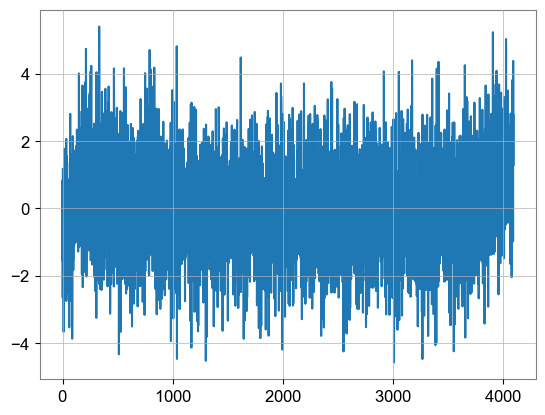

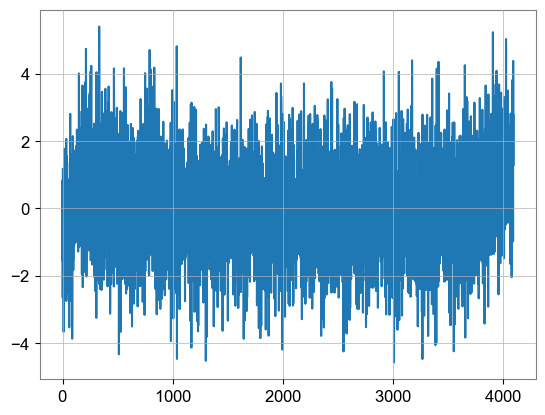

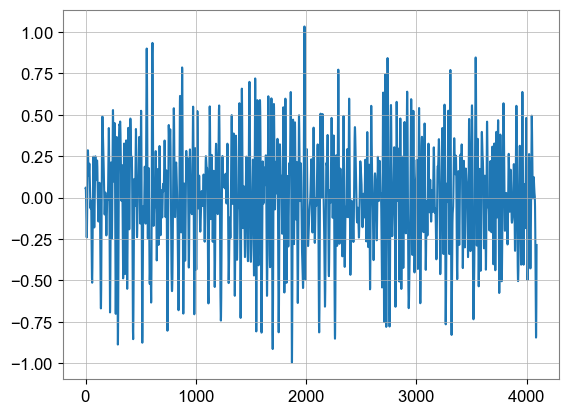

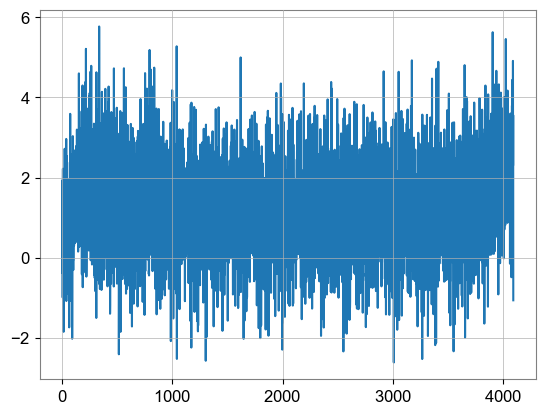

In [11]:
# Locating the matching waveforms among datasets

plt.plot(x_train_dec1_filt_arr[22702])
plt.show()
plt.plot(x_train_dec1[22702])
plt.show()
plt.plot(x_train_dec1_data_arr[22702])
plt.show()
plt.plot(x_train_dec1_raw[22702])
plt.show()

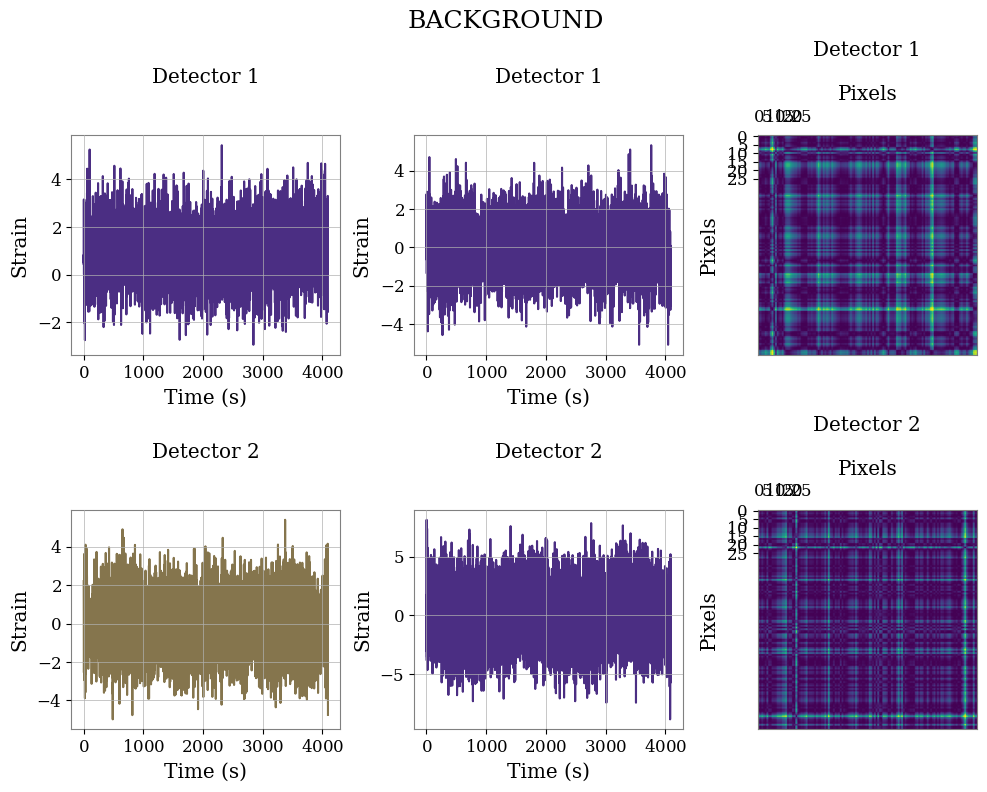

In [12]:
### -------------Background sample visualization------------- ###

# Plot background training data for Detector 1 and Detector 2
plt.figure(figsize = (10, 10), layout="constrained")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

x = np.arange(0,4096,1)

# Detector 1
# Vizualize background training samples
plt.subplot(3,3,1) 
plt.plot(x, glitch_train[13000,0,:], color="#4b2e83")
plt.title('Detector 1\n\n')
plt.xlabel("Time (s)")
plt.ylabel("Strain")

plt.subplot(3,3,2) 
plt.plot(x[0:4094], x_train_dec1[13000], color="#4b2e83")
plt.title('Detector 1\n\n')
plt.xlabel("Time (s)")
plt.ylabel("Strain")


# Vizualize background training samples in 2D
plt.subplot(3,3,3) 
plt.imshow(x_train[13000,0], cmap = 'viridis')
plt.title('Detector 1\n\nPixels')
plt.ylabel("Pixels")
plt.grid(None)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

# Detector 2
# Vizualize background training samples
plt.subplot(3,3,4) 
plt.plot(x, glitch_train[13000,1,:], color="#85754d")
plt.title("Detector 2\n\n")
plt.xlabel("Time (s)")
plt.ylabel("Strain")



plt.subplot(3,3,5) 
plt.plot(x[0:4094], x_train_dec2[13000], color="#4b2e83")
plt.title('Detector 2\n\n')
plt.xlabel("Time (s)")
plt.ylabel("Strain")

# Vizualize background training samples in 2D
plt.subplot(3,3,6) 
plt.imshow(x_train[13000,1], cmap = 'viridis')
plt.title("Detector 2\n\nPixels")
plt.ylabel("Pixels")
plt.grid(None)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

plt.suptitle('BACKGROUND', fontsize = 18)

# plt.savefig("example_bkg.png")
plt.show()

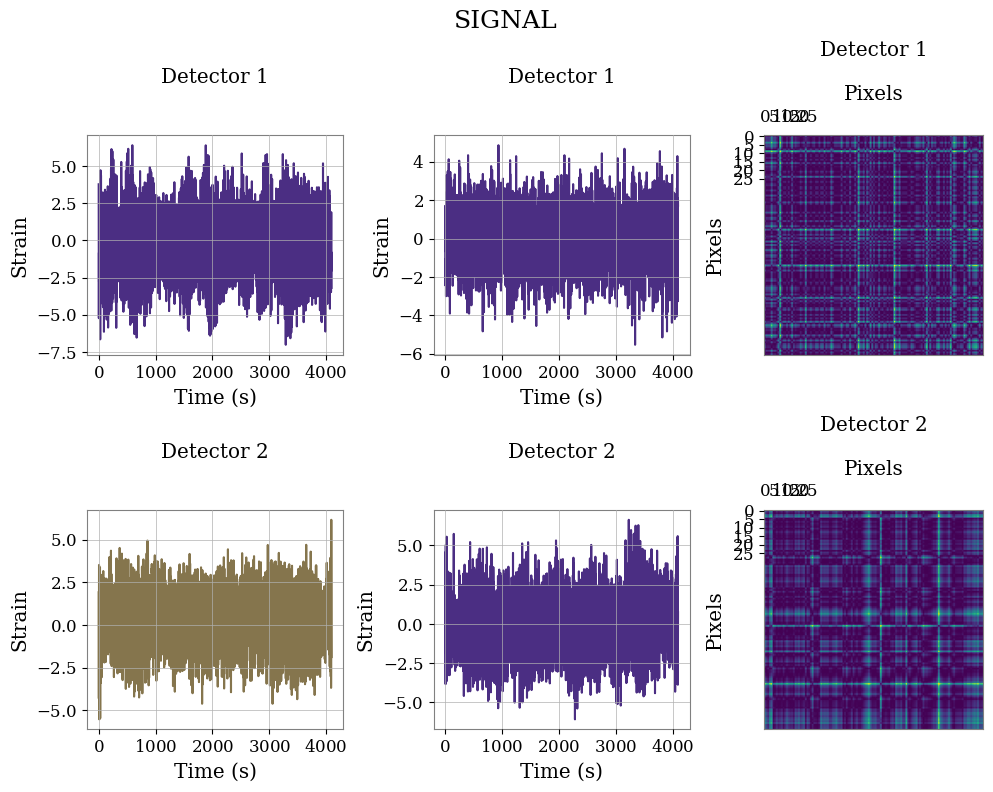

In [13]:
### -------------Signal sample visualization------------- ###

# Plot signal training data for Detector 1 and Detector 2
plt.figure(figsize = (10,10), layout="constrained")

# Detector 1
# Vizualize signal training samples
plt.subplot(3,3,1) 
plt.plot(x, bbh_train[969,0,:], color="#4b2e83")
plt.title('Detector 1\n\n')
plt.xlabel("Time (s)")
plt.ylabel("Strain")

plt.subplot(3,3,2) 
plt.plot(x[0:4094], x_train_dec1[14000], color="#4b2e83")
plt.title('Detector 1\n\n')
plt.xlabel("Time (s)")
plt.ylabel("Strain")

# Vizualize signal training samples in 2D
plt.subplot(3,3,3) 
plt.imshow(x_train[14000,0], cmap = 'viridis')
plt.title('Detector 1\n\nPixels')
plt.ylabel("Pixels")
plt.grid(None)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

# Detector 2
# Vizualize signal training samples
plt.subplot(3,3,4) 
plt.plot(x, bbh_train[969,1,:], color="#85754d")
plt.title("Detector 2\n\n")
plt.xlabel("Time (s)")
plt.ylabel("Strain")

plt.subplot(3,3,5) 
plt.plot(x[0:4094], x_train_dec2[14000], color="#4b2e83")
plt.title('Detector 2\n\n')
plt.xlabel("Time (s)")
plt.ylabel("Strain")

# Vizualize signal training samples in 2D
plt.subplot(3,3,6) 
plt.imshow(x_train[14000,1], cmap = 'viridis')
plt.title("Detector 2\n\nPixels")
plt.ylabel("Pixels")
plt.grid(None)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

plt.suptitle('SIGNAL', fontsize = 18)

# plt.savefig("example_signal.png")
plt.show()

#### Split Dataset

In [14]:
### -------------Split into training and validation datasets------------- ###

# Take the first 17.65% of our training features and targets as validation set
x_test= x_train[:round((len(x_train)*0.1072))]
y_test = y_train[:round((len(y_train)*0.1072))]

# Take the remaining 82.35% of training features and targets as training set
x_train = x_train[round((len(x_train)*0.1072)):]
y_train = y_train[round((len(y_train)*0.1072)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 80%, 13%, 2% split.
print("X Training Shape: ", x_train.shape)
print("Y Training Shape: ", y_train.shape)
print("X Validation Shape: ", x_val.shape)
print("Y Validation Shape: ", y_val.shape)
print("X Testing Shape: ", x_test.shape)
print("Y Testing Shape: ", y_test.shape)

X Training Shape:  (22854, 2, 129, 129)
Y Training Shape:  (22854,)
X Validation Shape:  (598, 2, 129, 129)
Y Validation Shape:  (598,)
X Testing Shape:  (2744, 2, 129, 129)
Y Testing Shape:  (2744,)


## Define Model

### Original architecture

In [15]:



### -------------Model Definition------------- ###

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

                # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
        self.fc1 = torch.nn.Linear(in_features=32*8*8, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

## Test architecture

In [21]:
# ### -------------Model Definition------------- ###

# class CNNModel(torch.nn.Module):
    
#     def __init__(self):
        
#         super(CNNModel, self).__init__()

#         # First convolution layer 
#         self.layer1 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=2, out_channels=64, kernel_size=5, stride=1, padding=2),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool2d(kernel_size=4, stride=2, padding=2),
#             torch.nn.Dropout(0.1)
#             )
        
#         # Second convolution layer 
#         self.layer2 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
#             torch.nn.BatchNorm2d(128),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             torch.nn.Dropout(0.5)
#             )


#         # Third convolution layer 
#         self.layer3 = torch.nn.Sequential(
#             torch.nn.Conv2d(in_channels=128, out_channels=32, kernel_size=5, stride=1, padding=2),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool2d(kernel_size=1, stride=2, padding=0),
#             torch.nn.Dropout(0.2)
#             )



#         # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
#         self.fc1 = torch.nn.Linear(in_features=32*5*5, out_features=256)
#         self.fc2 = torch.nn.Linear(in_features=256, out_features=64)
#         self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
#     def forward(self, x):

#         # input image -> conv -> batchnorm -> relu -> maxpool
#         out = self.layer1(x)
#         # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
#         out = self.layer2(out)
#         # 2nd maxpool output into 3rd conv layer
#         out = self.layer3(out)
#         # flatten the second maxpool output to be used as input into FCN layer
#         out = out.view(out.size(0), -1)

#         # Pass flattened output into FCN layers
#         out = self.fc1(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
        
#         return out

## Define Hyperparameters

In [16]:
### -------------Hyperparameters------------- ###

# Initialize the CNN model
model = CNNModel()
learning_rate = 0.0001      #0.00005
epochs = 40                 # 75
batchsize = 768
L2_reg = 0.001

# Define learning rate, epoch and batchsize for mini-batch gradient, and L2 regularization
# learning_rate = 0.000005
# epochs = 50
# batchsize = 768 # 768
# L2_reg = 0.00001
# L2_reg = learning_rate/epochs

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

if torch.cuda.is_available():                                  # Checks if the GPU is available for processing
    model.cuda()                                               # Sends the model to the GPU for processing
model        

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(2, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

## Identify Tracked Values

In [17]:
### -------------Identify tracked values------------- ###

train_loss_list_gasf = []
validation_accuracy_list_gasf = np.zeros((epochs,))

## Train Model

In [18]:
### -------------Training Model------------- ###

if torch.cuda.is_available():                   # If using CUDA version of PyTorch, dataset will be processed on GPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float().cuda()
    train_targets = torch.from_numpy(y_train).long().cuda()

    validation_inputs = torch.from_numpy(x_val).float().cuda()
    validation_targets = torch.from_numpy(y_val).long().cuda()

    testing_inputs = torch.from_numpy(x_test).float().cuda()
    testing_targets = torch.from_numpy(y_test).long().cuda()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

else:                                           # If not using CUDA version of PyTorch, dataset will be processed on CPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float()
    train_targets = torch.from_numpy(y_train).long()

    validation_inputs = torch.from_numpy(x_val).float()
    validation_targets = torch.from_numpy(y_val).long()

    testing_inputs = torch.from_numpy(x_test).float()
    testing_targets = torch.from_numpy(y_test).long()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

In [19]:
### -------------Training Loop------------- ###

for epoch in range(epochs):
    
    # Each mini-batch number i, grab i-th training feature and target mini-batch and perform fwd/bwd pass on the network
    
    for i in range(batch_split_num):
    
        optimizer.zero_grad()    
        train_batch_outputs = model(train_batches_features[i])
        loss = loss_func(train_batch_outputs, train_batches_targets[i])
        train_loss_list_gasf.append(loss.item())
        loss.backward()
        optimizer.step()

    ### -------------Compute Validation Accuracy------------- ###

    with torch.no_grad():

        validation_outputs = model(validation_inputs)
        correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor) 

        # print("Epoch: "+ str(epoch), 
        #       "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)


        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%',
              "Training loss: " + str(loss), flush=True)
        

        
        validation_accuracy_list_gasf[epoch] = correct.mean()

Epoch: 0 Validation Accuracy: 81.61%
Epoch: 1 Validation Accuracy: 83.78%
Epoch: 2 Validation Accuracy: 84.78%
Epoch: 3 Validation Accuracy: 87.79%
Epoch: 4 Validation Accuracy: 87.96%
Epoch: 5 Validation Accuracy: 87.96%
Epoch: 6 Validation Accuracy: 88.46%
Epoch: 7 Validation Accuracy: 89.13%
Epoch: 8 Validation Accuracy: 89.13%
Epoch: 9 Validation Accuracy: 89.63%
Epoch: 10 Validation Accuracy: 90.13%
Epoch: 11 Validation Accuracy: 90.3%
Epoch: 12 Validation Accuracy: 90.47%
Epoch: 13 Validation Accuracy: 90.64%
Epoch: 14 Validation Accuracy: 91.3%
Epoch: 15 Validation Accuracy: 91.3%
Epoch: 16 Validation Accuracy: 91.3%
Epoch: 17 Validation Accuracy: 91.47%
Epoch: 18 Validation Accuracy: 91.47%
Epoch: 19 Validation Accuracy: 91.64%
Epoch: 20 Validation Accuracy: 91.81%
Epoch: 21 Validation Accuracy: 91.64%
Epoch: 22 Validation Accuracy: 92.14%
Epoch: 23 Validation Accuracy: 92.31%
Epoch: 24 Validation Accuracy: 92.47%
Epoch: 25 Validation Accuracy: 92.31%
Epoch: 26 Validation Accur

## Visualize & Evaluate Model

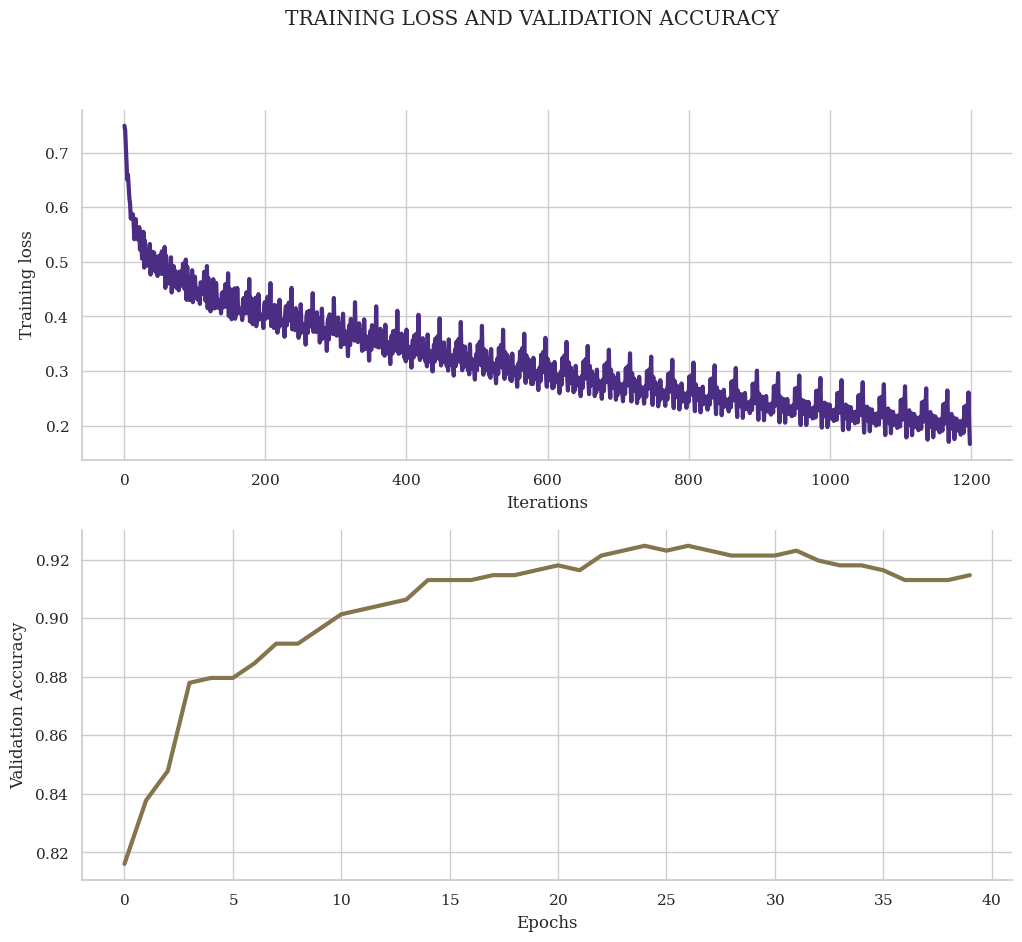

In [20]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list_gasf, linewidth = 3, color="#4b2e83")
plt.ylabel("Training loss")
plt.xlabel("Iterations")


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_gasf, linewidth = 3, color = "#85754d")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")
plt.suptitle("TRAINING LOSS AND VALIDATION ACCURACY")
sns.despine()

# plt.savefig("trainLoss_valAcc.png")

In [21]:
### -------------Computing the Training accuracy------------- ###

# torch.cuda.empty_cache()
with torch.no_grad():

    target_pred_test = model(train_inputs)
    correct = (torch.argmax(target_pred_test, dim=1) == train_targets).type(torch.FloatTensor)
    testing_acc = (correct.mean().numpy()*100)
    
    print("Training Accuracy: {:.2f}%".format(testing_acc))

Training Accuracy: 91.85%


In [22]:
### -------------Computing the testing accuracy------------- ###

# torch.cuda.empty_cache()
with torch.no_grad():

    target_pred_test = model(testing_inputs)
    correct = (torch.argmax(target_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    testing_acc = (correct.mean().numpy()*100)
    
    print("Testing Accuracy: {:.2f}%".format(testing_acc))

Testing Accuracy: 87.03%


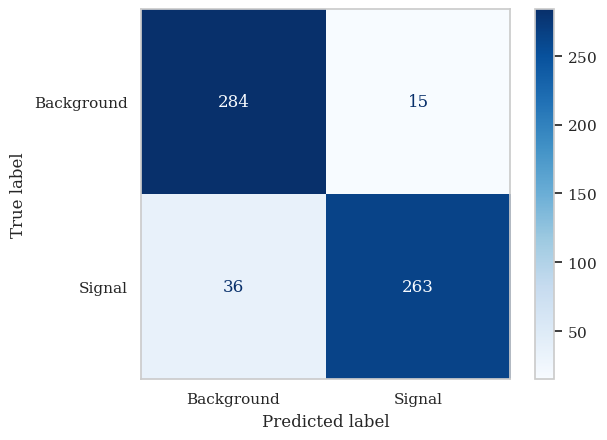

{'Accuracy': 0.9147157190635451, 'Precision': 0.9460431654676259, 'Sensitivity_recall': 0.8795986622073578, 'Specificity': 0.9498327759197325, 'F1_score': 0.9116117850953207}


In [23]:
#---- Confusion Matrix ----#

actual = validation_targets.cpu().numpy()
predicted = (torch.argmax(model(validation_inputs), dim=1)).cpu().numpy()

cm = confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                            display_labels = ('Background', 'Signal'))
cm_display.plot(cmap=plt.cm.Blues, values_format = '')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
plt.grid(False)
# plt.savefig("conf_matrix_GASF.png")
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)
#metrics
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


#### Incorrect Predictions

In [84]:
# ### -------------Incorrect model predictions------------- ###

# # Let's show some of our signals that have been classified incorrectly.
# incorrect_index = np.array(np.where(correct == 0))          # Finds the index of the incorrect predictions
# resized_testing_inputs = np.reshape(testing_inputs.cpu()
#                                     .numpy(), (len(testing_inputs),2,34,34)) # Reshapes the testing inputs to (21908,2,34,34), moves to CPU 
#                                                             # and converts to numpy                                                       
# pred_test = target_pred_test.cpu().numpy()                  # Moves model testing outputs to CPU and converts to numpy

# x = np.arange(0,4096,1)
# rand_inc_idx_list = []

# plt.figure(figsize = (15, 15), layout="constrained")
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.sans-serif"] = "Open Sans"
# np.random.seed(1)

# for i in range(4):
#     # Choose random index for an image from our incorrectly classified images to analyze.
#     rand_idx = np.random.choice(incorrect_index[0,:])
#     rand_inc_idx_list.append(rand_idx.item())
    
#     plt.subplot(4,4,i*4 + 1)
#     plt.imshow(resized_testing_inputs[rand_idx,0], cmap = 'viridis')
#     plt.title('Detector 1\n\nPixels')
#     plt.ylabel("Pixels")
#     plt.grid(None)
#     plt.xticks([0, 5, 10, 15, 20, 25])
#     plt.yticks([0, 5, 10, 15, 20, 25])
#     plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

#     # Adds text to subplots and prints out the incorrect prediction of the model
#     plt.text(-19, 4, "Prediction: {}".format(list(anomaly_class.keys())
#                                                 [list(anomaly_class.values()).index(np.argmax(pred_test[rand_idx][:]))])
#                                                 , ha='center', color='red')    
#     # Adds text to subplots and prints out the correct target item
#     plt.text(-19, 9, "Actual: {}".format(list(anomaly_class.keys())
#                                              [list(anomaly_class.values()).index(y_test[rand_idx])])
#                                              , ha='center', color='red')

#     plt.subplot(4,4,i*4 + 2)  
#     plt.plot(x,x_val_data[rand_idx,:,0], color="#4b2e83")                                                                                                   ### NOTE: MIGHT NEED TO CHANGE TO x_test_data
#     plt.title('Detector 1\n\n')
#     plt.xlabel("Time (s)")
#     plt.ylabel("Strain")

#     plt.subplot(4,4,i*4 + 3)  
#     plt.imshow(resized_testing_inputs[rand_idx,1], cmap = 'viridis')
#     plt.title('Detector 2\n\nPixels')
#     plt.ylabel("Pixels")
#     plt.grid(None)
#     plt.xticks([0, 5, 10, 15, 20, 25])
#     plt.yticks([0, 5, 10, 15, 20, 25])
#     plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

#     plt.subplot(4,4,i*4 + 4)  
#     plt.plot(x,x_val_data[rand_idx,:,1], color="#b7a57a")
#     plt.title('Detector 2\n\n')
#     plt.xlabel("Time (s)")
#     plt.ylabel("Strain")

# plt.suptitle("INCORRECTLY CLASSIFIED SIGNALS", fontsize= 18)

# # plt.savefig("Incorrect_results.png")
# plt.show()

#### Correct Predictions

In [85]:
# ### -------------Correct model predictions------------- ###

# # Now, let's show some of our signals that have been classified correctly.
# correct_index = np.array(np.where(correct == 1))          # Finds the index of the incorrect predictions
# resized_testing_inputs = np.reshape(testing_inputs.cpu()
#                                     .numpy(), (len(testing_inputs),2,34,34)) # Reshapes the testing inputs to (21908,2,34,34), moves to CPU 
#                                                             # and converts to numpy                                                       
# pred_test = target_pred_test.cpu().numpy()                  # Moves model testing outputs to CPU and converts to numpy

# x = np.arange(0,4096,1)
# rand_cor_idx_list = []

# plt.figure(figsize = (15, 15), layout="constrained")
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.sans-serif"] = "Open Sans"
# np.random.seed(1)

# for i in range(4):
#     # Choose random index for an image from our correctly classified images to analyze.
#     rand_idx = np.random.choice(correct_index[0,:])
#     rand_cor_idx_list.append(rand_idx.item())
    
#     plt.subplot(4,4,i*4 + 1)   
#     plt.imshow(resized_testing_inputs[rand_idx,0], cmap = 'viridis')
#     plt.title('Detector 1\n\nPixels')
#     plt.ylabel("Pixels")
#     plt.grid(None)
#     plt.xticks([0, 5, 10, 15, 20, 25])
#     plt.yticks([0, 5, 10, 15, 20, 25])
#     plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

#     # Adds text to subplots and prints out the incorrect prediction of the model
#     plt.text(-19, 4, "Prediction: {}".format(list(anomaly_class.keys())
#                                                 [list(anomaly_class.values()).index(np.argmax(pred_test[rand_idx][:]))])
#                                                 , ha='center', color='red')    
#     # Adds text to subplots and prints out the correct target item
#     plt.text(-19, 9, "Actual: {}".format(list(anomaly_class.keys())
#                                              [list(anomaly_class.values()).index(y_val[rand_idx])])
#                                              , ha='center', color='red')

#     plt.subplot(4,4,i*4 + 2)  
#     plt.plot(x,x_val_data[rand_idx,:,0], color="#4b2e83")
#     plt.title('Detector 1\n\n')
#     plt.xlabel("Time (s)")
#     plt.ylabel("Strain")

#     plt.subplot(4,4,i*4 + 3)  
#     plt.imshow(resized_testing_inputs[rand_idx,1], cmap = 'viridis')
#     plt.title('Detector 2\n\nPixels')
#     plt.ylabel("Pixels")
#     plt.grid(None)
#     plt.xticks([0, 5, 10, 15, 20, 25])
#     plt.yticks([0, 5, 10, 15, 20, 25])
#     plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

#     plt.subplot(4,4,i*4 + 4)  
#     plt.plot(x,x_val_data[rand_idx,:,1], color="#b7a57a")
#     plt.title('Detector 2\n\n')
#     plt.xlabel("Time (s)")
#     plt.ylabel("Strain")

# plt.suptitle("CORRECTLY CLASSIFIED SIGNALS", fontsize= 18)

# # plt.savefig("Correct_results.png")
# plt.show()

In [86]:
# ### -------------Data comparison plots------------- ###

# # Comparison plots of the 4 types of signals with their corresponding GASF images

# list_data_idx = [7579, 239, 14245, 17911]
# list_signal = ["GLITCH SIGNAL", "BACKGROUND SIGNAL", "SINE-GAUSSIAN SIGNAL", "BINARY BLACK HOLE SIGNAL"]
# i = 0
# for data_idx in list_data_idx:

#     line_width = 2
#     plt.figure(figsize = (7, 7), layout="constrained")
#     plt.rcParams["font.family"] = "serif"
#     plt.rcParams["font.sans-serif"] = "Open Sans"

#     plt.subplot(2,2,1)   
#     plt.imshow(resized_testing_inputs[data_idx,0], cmap = 'viridis')
#     plt.title('Detector 1\n\nPixels')

#     plt.grid(None)
#     plt.ylabel("Pixels")
#     plt.xticks([0, 5, 10, 15, 20, 25])
#     plt.yticks([0, 5, 10, 15, 20, 25])
#     plt.tick_params(axis='both', bottom=False, top=False, labelbottom=False, labeltop=True)


#     plt.subplot(2, 2, 2)  
#     plt.imshow(resized_testing_inputs[data_idx,1], cmap = 'viridis')
#     plt.title('Detector 2\n\nPixels')
#     plt.grid(None)
#     plt.ylabel("Pixels")
#     plt.xticks([0, 5, 10, 15, 20, 25])
#     plt.yticks([0, 5, 10, 15, 20, 25])
#     plt.tick_params(axis='both', bottom=False, top=False, labelbottom=False, labeltop=True)


#     plt.subplot(2,2,3)  
#     plt.plot(x,x_val_data[data_idx,:,0], color="#4b2e83", linewidth = line_width)
#     plt.title('Detector 1')
#     plt.xlabel("Time (s)")
#     plt.ylabel("Strain")


#     plt.subplot(2,2,4)  
#     plt.plot(x,x_val_data[data_idx,:,1], color="#b7a57a", linewidth = line_width)
#     plt.title('Detector 2')
#     plt.xlabel("Time (s)")
#     plt.ylabel("Strain")
#     plt.suptitle(list_signal[i], fontsize= 16)

#     i = i + 1
#     # plt.savefig("GLITCH.png")
#     plt.show()

# SPECTROGRAMS
#### Retreive Dataset For SPECTROGRAMS

In [43]:
torch.cuda.empty_cache()

In [45]:
### -------------Load dataset------------- ###

# Define the file name
filename = 'classify_data.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bbh_train = np.array(file['Training']['bbh'])
    bbh_val = np.array(file['Validation']['bbh'])
    glitch_train = np.array(file['Training']['glitch'])
    glitch_val = np.array(file['Validation']['glitch'])

In [46]:
### -------------Label our data as background or signal------------- ###

# Allows us to easily apply labels to our data to denote it as signal or background for classification.
anomaly_class = {
    'Glitch': 0,
    'Signal': 1
}

# ID our data as background or signal.
glitch_train_ids = np.full(glitch_train.shape[0], anomaly_class['Glitch'], dtype=int)
glitch_val_ids = np.full(glitch_val.shape[0], anomaly_class['Glitch'], dtype=int)

bbh_train_ids = np.full(bbh_train.shape[0], anomaly_class['Signal'], dtype=int)
bbh_val_ids = np.full(bbh_val.shape[0], anomaly_class['Signal'], dtype=int)

In [47]:
### -------------Merge dataset------------- ###

# Stick our background and signal data together for training and testing.
x_train = np.concatenate((glitch_train, bbh_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)

x_val_data = np.concatenate((glitch_val, bbh_val), axis=0).transpose((0,2,1))
y_val = np.concatenate((glitch_val_ids, bbh_val_ids), axis=0)

In [48]:
### -------------Shuffle dataset------------- ###

# Shuffle the training data using a randomly chosen permutation. This ensures we don't encounter artifacts from background 
# and signal data being clumped together.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

#### Convert Data to Images

In [49]:
### -------------Split detector dataset------------- ###

# Each 2D dataset of gravitational wave data comes from one of two detectors: 0 (located in Hanford, WA) and 1 
# (located in Livingston, LA). Split the data from these two detectors since we can only pass 2D images into our CNN to train.
x_train_dec1 = x_train[:,:,0]
x_train_dec2 = x_train[:,:,1]

x_val_dec1 = x_val_data[:,:,0]
x_val_dec2 = x_val_data[:,:,1]

In [30]:
data = (x_train_dec1[14000,:])
npseg=255
nolap = npseg-30



# NOTE: Prepare FFT!!!!!
# fft 0.1 s
# stride 0.05
# print(datas[d].shape)

# TimeSeries(
#     np.random.normal(0, 1, 4096),
#     sample_rate=4096
# ).spectrogram(stride=.025).value.shape



series = (TimeSeries(data, sample_rate = 4096, unit='s', name='test', t0=0))     #np.array --> constantQ.timeseries   


f, t, Sxx = signal.spectrogram(series, fs = 4096, nperseg=npseg, noverlap = nolap) #return_onesided = True) 
Sxx.shape

(128, 128)

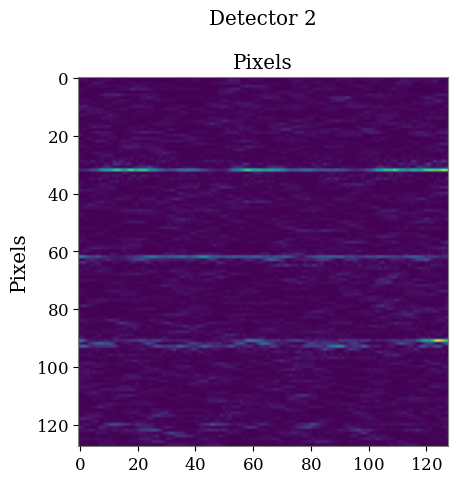

In [31]:
x = np.arange(0,1366,1)


# plt.plot(x, Sxx, color="#85754d")
# plt.title("Detector 2\n\n")
# plt.xlabel("Time (s)")
# plt.ylabel("Strain")



plt.imshow(Sxx, cmap = 'viridis')
plt.title("Detector 2\n\nPixels")
plt.ylabel("Pixels")
plt.grid(None)
# plt.xticks([0, 5, 10, 15, 20, 25])
# plt.yticks([0, 5, 10, 15, 20, 25])
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

In [9]:
# Utilize spectrograms


data_list = []
series_list = []
Sxx_list = []
f_list = []
t_list = []
npseg=255
nolap = npseg-30

# datas = [0 ,1, 2, 3]
datas = [x_train_dec1, x_train_dec2, x_val_dec1, x_val_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    Sxx_list = []
    f_list = []
    t_list = []
    npseg=255
    nolap = npseg-30

    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, unit='s', name='test', t0=0))     #np.array --> constantQ.timeseries   
        series_list.append(series)

        f, t, Sxx = signal.spectrogram(series, fs = 4096, nperseg=npseg, noverlap = nolap) #return_onesided = True) 
        Sxx_list.append(Sxx)
        # f_list.append(f)
        # t_list.append(t)
        # print(d)

    if d == 0:
        data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec1 = np.asarray(series_list)
        Sxx_arr_x_train_dec1 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_train_dec1 = np.asarray(f_list)
        # t_arr_x_train_dec1 = np.asarray(t_list)
    elif d == 1:
        data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec2 = np.asarray(series_list)
        Sxx_arr_x_train_dec2 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_train_dec2 = np.asarray(f_list)
        # t_arr_x_train_dec2 = np.asarray(t_list)
    elif d == 2:
        data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec1 = np.asarray(series_list)
        Sxx_arr_x_test_dec1 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_test_dec1 = np.asarray(f_list)
        # t_arr_x_test_dec1 = np.asarray(t_list)
    else:
        data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec2 = np.asarray(series_list)
        Sxx_arr_x_test_dec2 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_test_dec2 = np.asarray(f_list)
        # t_arr_x_test_dec2 = np.asarray(t_list)

In [10]:
img_x_train_dec1 = Sxx_arr_x_train_dec1
img_x_train_dec2 = Sxx_arr_x_train_dec2
img_x_val_dec1 = Sxx_arr_x_test_dec1
img_x_val_dec2 = Sxx_arr_x_test_dec2

In [ ]:
# plt.imshow(img_x_train_dec1[1])
# plt.xticks([0, 5, 10, 15, 20, 25])
# plt.yticks([0, 5, 10, 15, 20, 25])
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

In [ ]:
# x = np.arange(0,34,1)
# plt.pcolormesh(x, img_x_train_dec1[1,:], img_x_train_dec1[1,:,:])
# plt.show()


#### Flatten Images

In [101]:
### -------------Flatten dataset------------- ###

# First, flatten each image into 784 to convert features from 3D -> 2D arrays
x_train_flat_dec1 = img_x_train_dec1.reshape((len(img_x_train_dec1), 129 * 129))
x_train_flat_dec2 = img_x_train_dec2.reshape((len(img_x_train_dec2), 129 * 129))

x_val_flat_dec1 = img_x_val_dec1.reshape((len(img_x_val_dec1), 129 * 129))
x_val_flat_dec2 = img_x_val_dec2.reshape((len(img_x_val_dec2), 129 * 129))

# Check the shapes of training/testing datasets
print("Training Features Detector 1 Shape: ", x_train_flat_dec1.shape)
print("Training Features Detector 2 Shape: ", x_train_flat_dec2.shape)
print("Validation Features Detector 1 Shape: ", x_val_flat_dec1.shape)
print("Validation Features Detector 2 Shape: ", x_val_flat_dec2.shape)

Training Features Detector 1 Shape:  (25598, 16641)
Training Features Detector 2 Shape:  (25598, 16641)
Validation Features Detector 1 Shape:  (598, 16641)
Validation Features Detector 2 Shape:  (598, 16641)


#### Scale and reshape dataset

In [102]:
### -------------Scale dataset------------- ###

# Use the StandardScaler library to ensure our data has mean 0 and STD 1
scaler = StandardScaler()
img_x_train_dec1 = scaler.fit_transform(x_train_flat_dec1).reshape((len(img_x_train_dec1), 129, 129))
img_x_train_dec2 = scaler.fit_transform(x_train_flat_dec2).reshape((len(img_x_train_dec2), 129, 129))

img_x_val_dec1 = scaler.fit_transform(x_val_flat_dec1).reshape((len(img_x_val_dec1), 129, 129))
img_x_val_dec2 = scaler.fit_transform(x_val_flat_dec2).reshape((len(img_x_val_dec2), 129, 129))

# Check the shapes of training/testing datasets
print("Training Features Detector 1 Shape: ", img_x_train_dec1.shape)
print("Training Features Detector 2 Shape: ", img_x_train_dec2.shape)
print("Validation Features Detector 1 Shape: ", img_x_val_dec1.shape)
print("Validation Features Detector 2 Shape: ", img_x_val_dec2.shape)

Training Features Detector 1 Shape:  (25598, 129, 129)
Training Features Detector 2 Shape:  (25598, 129, 129)
Validation Features Detector 1 Shape:  (598, 129, 129)
Validation Features Detector 2 Shape:  (598, 129, 129)


#### Stack Detector Datasets

In [11]:
# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)

#### Sample Data Visualization

Before we define our neural network and start training, let's take a look at some of our background and signal data to compare them.

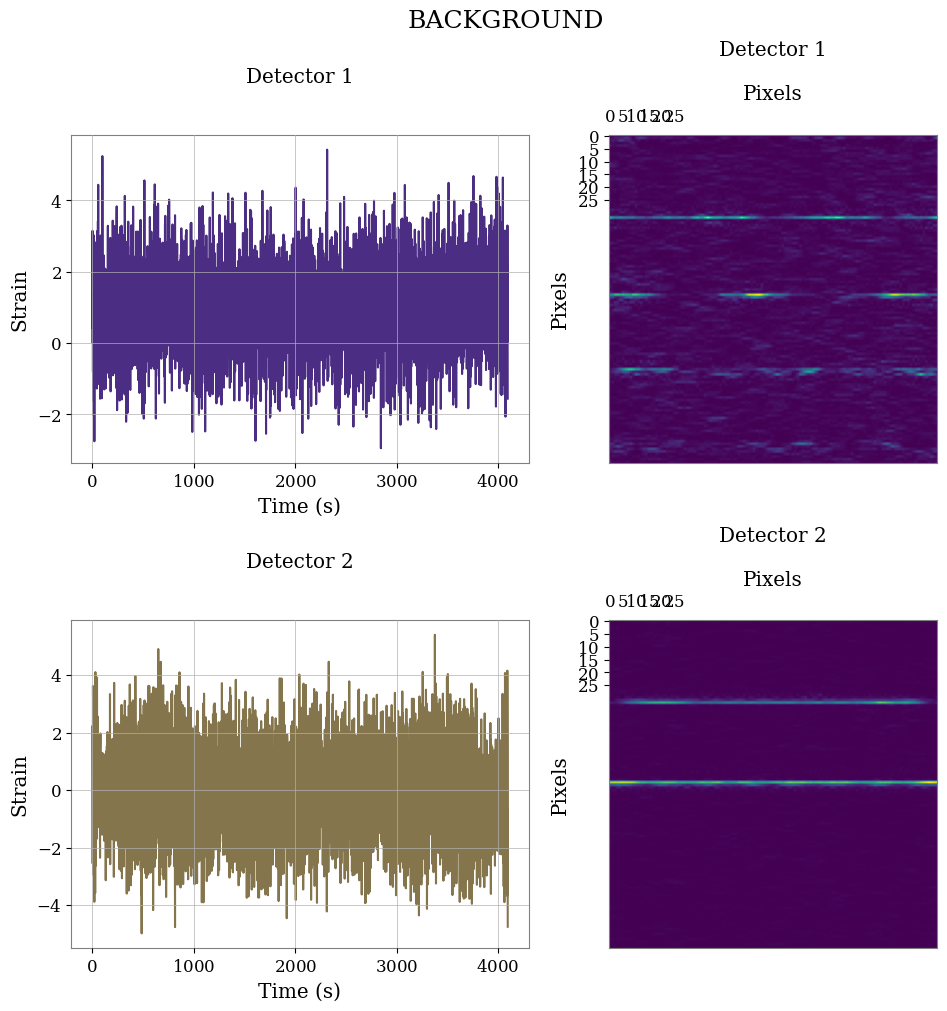

In [35]:
### -------------Background sample visualization------------- ###

# Plot background training data for Detector 1 and Detector 2
plt.figure(figsize = (10, 10), layout="constrained")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

x = np.arange(0,4096,1)

# Detector 1
# Vizualize background training samples
plt.subplot(2,2,1) 
plt.plot(x, glitch_train[13000,0,:], color="#4b2e83")
plt.title('Detector 1\n\n')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
# Vizualize background training samples in 2D
plt.subplot(2,2,2) 
plt.imshow(x_train[13000,0], cmap = 'viridis')
plt.title('Detector 1\n\nPixels')
plt.ylabel("Pixels")
plt.grid(None)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

# Detector 2
# Vizualize background training samples
plt.subplot(2,2,3) 
plt.plot(x, glitch_train[13000,1,:], color="#85754d")
plt.title("Detector 2\n\n")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
# Vizualize background training samples in 2D
plt.subplot(2,2,4) 
plt.imshow(x_train[13000,1], cmap = 'viridis')
plt.title("Detector 2\n\nPixels")
plt.ylabel("Pixels")
plt.grid(None)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

plt.suptitle('BACKGROUND', fontsize = 18)

# plt.savefig("example_bkg.png")
plt.show()

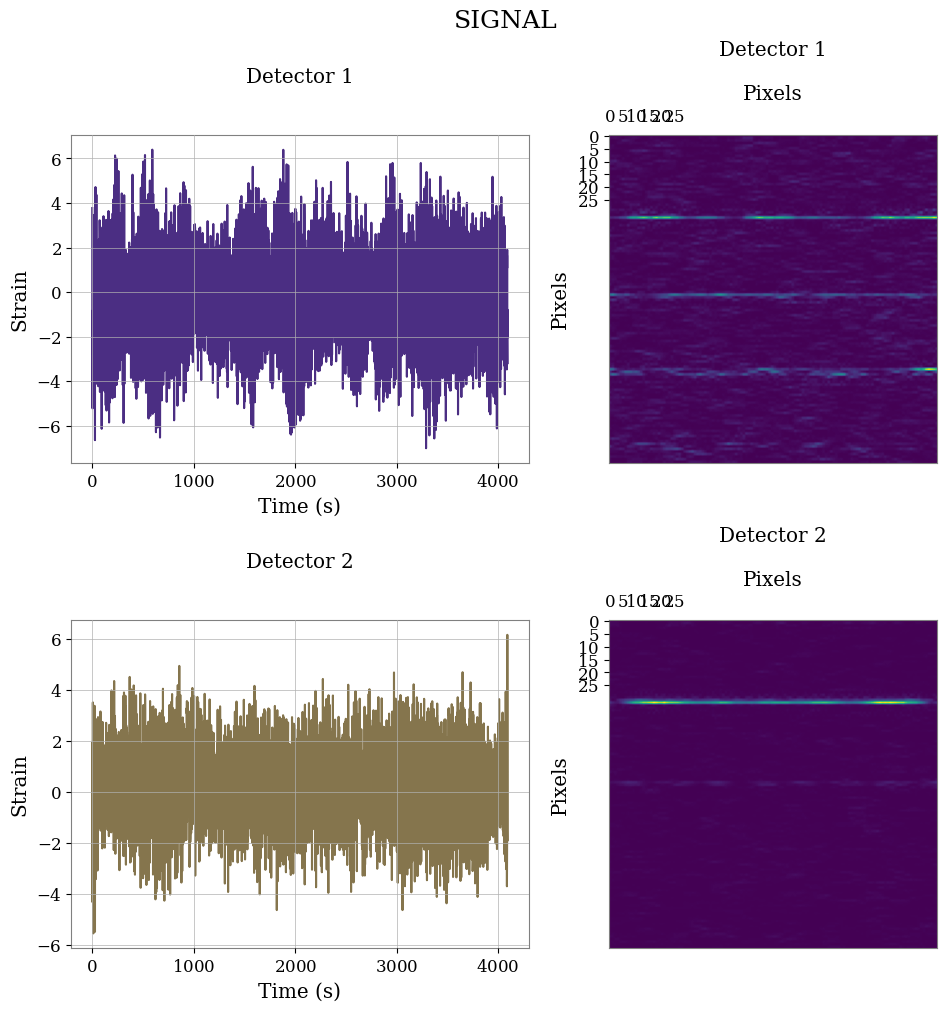

In [36]:
### -------------Signal sample visualization------------- ###

# Plot signal training data for Detector 1 and Detector 2
plt.figure(figsize = (10,10), layout="constrained")

# Detector 1
# Vizualize signal training samples
plt.subplot(2,2,1) 
plt.plot(x, bbh_train[969,0,:], color="#4b2e83")
plt.title('Detector 1\n\n')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
# Vizualize signal training samples in 2D
plt.subplot(2,2,2) 
plt.imshow(x_train[14000,0], cmap = 'viridis')
plt.title('Detector 1\n\nPixels')
plt.ylabel("Pixels")
plt.grid(None)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

# Detector 2
# Vizualize signal training samples
plt.subplot(2,2,3) 
plt.plot(x, bbh_train[969,1,:], color="#85754d")
plt.title("Detector 2\n\n")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
# Vizualize signal training samples in 2D
plt.subplot(2,2,4) 
plt.imshow(x_train[14000,1], cmap = 'viridis')
plt.title("Detector 2\n\nPixels")
plt.ylabel("Pixels")
plt.grid(None)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

plt.suptitle('SIGNAL', fontsize = 18)

# plt.savefig("example_signal.png")
plt.show()

#### Split Dataset

In [12]:
### -------------Split into training and validation datasets------------- ###

# Take the first 17.65% of our training features and targets as validation set
x_test= x_train[:round((len(x_train)*0.1072))]
y_test = y_train[:round((len(y_train)*0.1072))]

# Take the remaining 82.35% of training features and targets as training set
x_train = x_train[round((len(x_train)*0.1072)):]
y_train = y_train[round((len(y_train)*0.1072)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 80%, 13%, 2% split.
print("X Training Shape: ", x_train.shape)
print("Y Training Shape: ", y_train.shape)
print("X Validation Shape: ", x_val.shape)
print("Y Validation Shape: ", y_val.shape)
print("X Testing Shape: ", x_test.shape)
print("Y Testing Shape: ", y_test.shape)

X Training Shape:  (22854, 2, 128, 128)
Y Training Shape:  (22854,)
X Validation Shape:  (598, 2, 128, 128)
Y Validation Shape:  (598,)
X Testing Shape:  (2744, 2, 128, 128)
Y Testing Shape:  (2744,)


## Define Model

In [13]:
### -------------Model Definition------------- ###

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

        # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
        self.fc1 = torch.nn.Linear(in_features=32*8*8, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

## Define Hyperparameters

In [14]:
### -------------Hyperparameters------------- ###

# Initialize the CNN model
model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient, and L2 regularization
learning_rate = 0.00005
epochs = 75
batchsize = 781
L2_reg = 0.001

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

if torch.cuda.is_available():                                  # Checks if the GPU is available for processing
    model.cuda()                                               # Sends the model to the GPU for processing
model        

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

## Identify Tracked Values

In [15]:
### -------------Identify tracked values------------- ###

train_loss_list_spec = []
validation_accuracy_list_spec = np.zeros((epochs,))

## Train Model

In [16]:
### -------------Training Model------------- ###

if torch.cuda.is_available():                   # If using CUDA version of PyTorch, dataset will be processed on GPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float().cuda()
    train_targets = torch.from_numpy(y_train).long().cuda()

    validation_inputs = torch.from_numpy(x_val).float().cuda()
    validation_targets = torch.from_numpy(y_val).long().cuda()

    testing_inputs = torch.from_numpy(x_test).float().cuda()
    testing_targets = torch.from_numpy(y_test).long().cuda()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

else:                                           # If not using CUDA version of PyTorch, dataset will be processed on CPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float()
    train_targets = torch.from_numpy(y_train).long()

    validation_inputs = torch.from_numpy(x_val).float()
    validation_targets = torch.from_numpy(y_val).long()

    testing_inputs = torch.from_numpy(x_test).float()
    testing_targets = torch.from_numpy(y_test).long()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

In [17]:
### -------------Training Loop------------- ###

for epoch in range(epochs):
    
    # Each mini-batch number i, grab i-th training feature and target mini-batch and perform fwd/bwd pass on the network
    
    for i in range(batch_split_num):
    
        optimizer.zero_grad()    
        train_batch_outputs = model(train_batches_features[i])

        loss = loss_func(train_batch_outputs, train_batches_targets[i])
        train_loss_list_spec.append(loss.item())
        
        loss.backward()
        optimizer.step()

    ### -------------Compute Validation Accuracy------------- ###

    with torch.no_grad():

        validation_outputs = model(validation_inputs)
        correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor)                
        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)
        
        validation_accuracy_list_spec[epoch] = correct.mean()

Epoch: 0 Validation Accuracy: 38.46%
Epoch: 1 Validation Accuracy: 50.0%
Epoch: 2 Validation Accuracy: 50.0%
Epoch: 3 Validation Accuracy: 50.0%
Epoch: 4 Validation Accuracy: 50.0%
Epoch: 5 Validation Accuracy: 50.0%
Epoch: 6 Validation Accuracy: 50.0%
Epoch: 7 Validation Accuracy: 50.0%
Epoch: 8 Validation Accuracy: 50.0%
Epoch: 9 Validation Accuracy: 50.0%
Epoch: 10 Validation Accuracy: 50.0%
Epoch: 11 Validation Accuracy: 50.0%
Epoch: 12 Validation Accuracy: 50.0%
Epoch: 13 Validation Accuracy: 50.0%
Epoch: 14 Validation Accuracy: 50.0%
Epoch: 15 Validation Accuracy: 50.0%
Epoch: 16 Validation Accuracy: 50.0%
Epoch: 17 Validation Accuracy: 50.0%
Epoch: 18 Validation Accuracy: 50.0%
Epoch: 19 Validation Accuracy: 50.0%
Epoch: 20 Validation Accuracy: 50.0%
Epoch: 21 Validation Accuracy: 50.0%
Epoch: 22 Validation Accuracy: 50.0%
Epoch: 23 Validation Accuracy: 50.0%
Epoch: 24 Validation Accuracy: 50.0%
Epoch: 25 Validation Accuracy: 50.0%
Epoch: 26 Validation Accuracy: 50.0%
Epoch: 27 

## Visualize & Evaluate Model

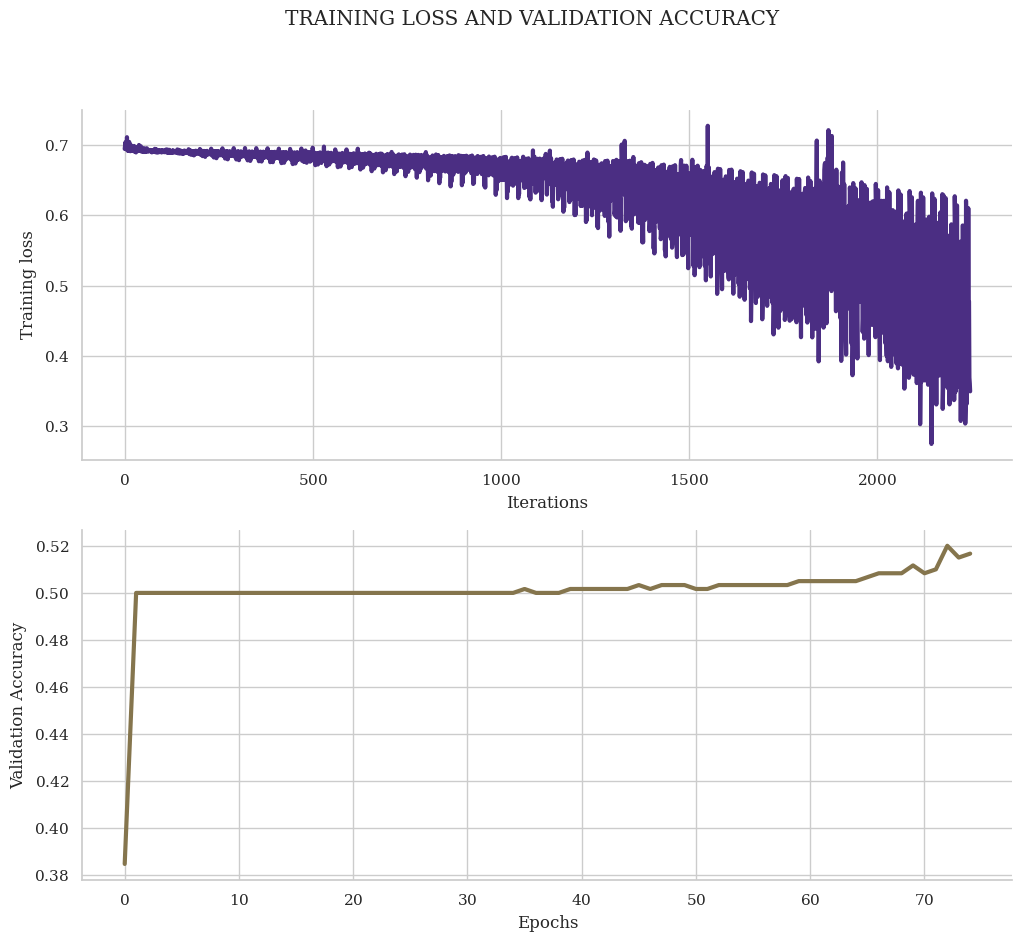

In [18]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list_spec, linewidth = 3, color="#4b2e83")
plt.ylabel("Training loss")
plt.xlabel("Iterations")


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_spec, linewidth = 3, color = "#85754d")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")
plt.suptitle("TRAINING LOSS AND VALIDATION ACCURACY")
sns.despine()

# plt.savefig("trainLoss_valAcc.png")

In [19]:
### -------------Computing the testing accuracy------------- ###

# torch.cuda.empty_cache()
with torch.no_grad():

    target_pred_test = model(testing_inputs)
    correct = (torch.argmax(target_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    testing_acc = (correct.mean().numpy()*100)
    
    print("Testing Accuracy: {:.2f}%".format(testing_acc))

Testing Accuracy: 85.60%


In [20]:
### -------------Computing the Training accuracy------------- ###

# torch.cuda.empty_cache()
with torch.no_grad():

    target_pred_test = model(train_inputs)
    correct = (torch.argmax(target_pred_test, dim=1) == train_targets).type(torch.FloatTensor)
    testing_acc = (correct.mean().numpy()*100)
    
    print("Training Accuracy: {:.2f}%".format(testing_acc))

Training Accuracy: 78.56%


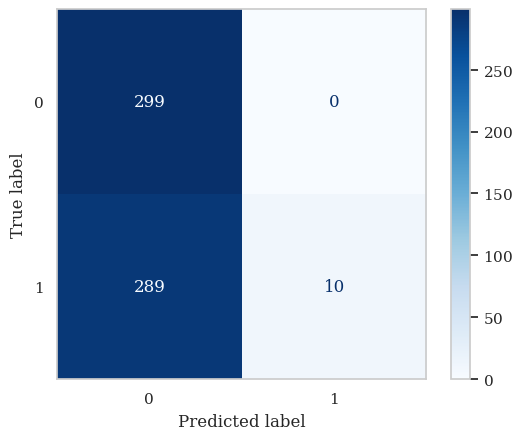

{'Accuracy': 0.5167224080267558, 'Precision': 1.0, 'Sensitivity_recall': 0.033444816053511704, 'Specificity': 1.0, 'F1_score': 0.06472491909385113}


In [21]:
#---- Confusion Matrix ----#

actual = validation_targets.cpu().numpy()
predicted = (torch.argmax(model(validation_inputs), dim=1)).cpu().numpy()

cm = confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                            display_labels = None)
cm_display.plot(cmap=plt.cm.Blues, values_format = '')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
plt.grid(False)
# plt.savefig("conf_matrix_spectrogram.png")
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)
#metrics
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


#### Incorrect Predictions

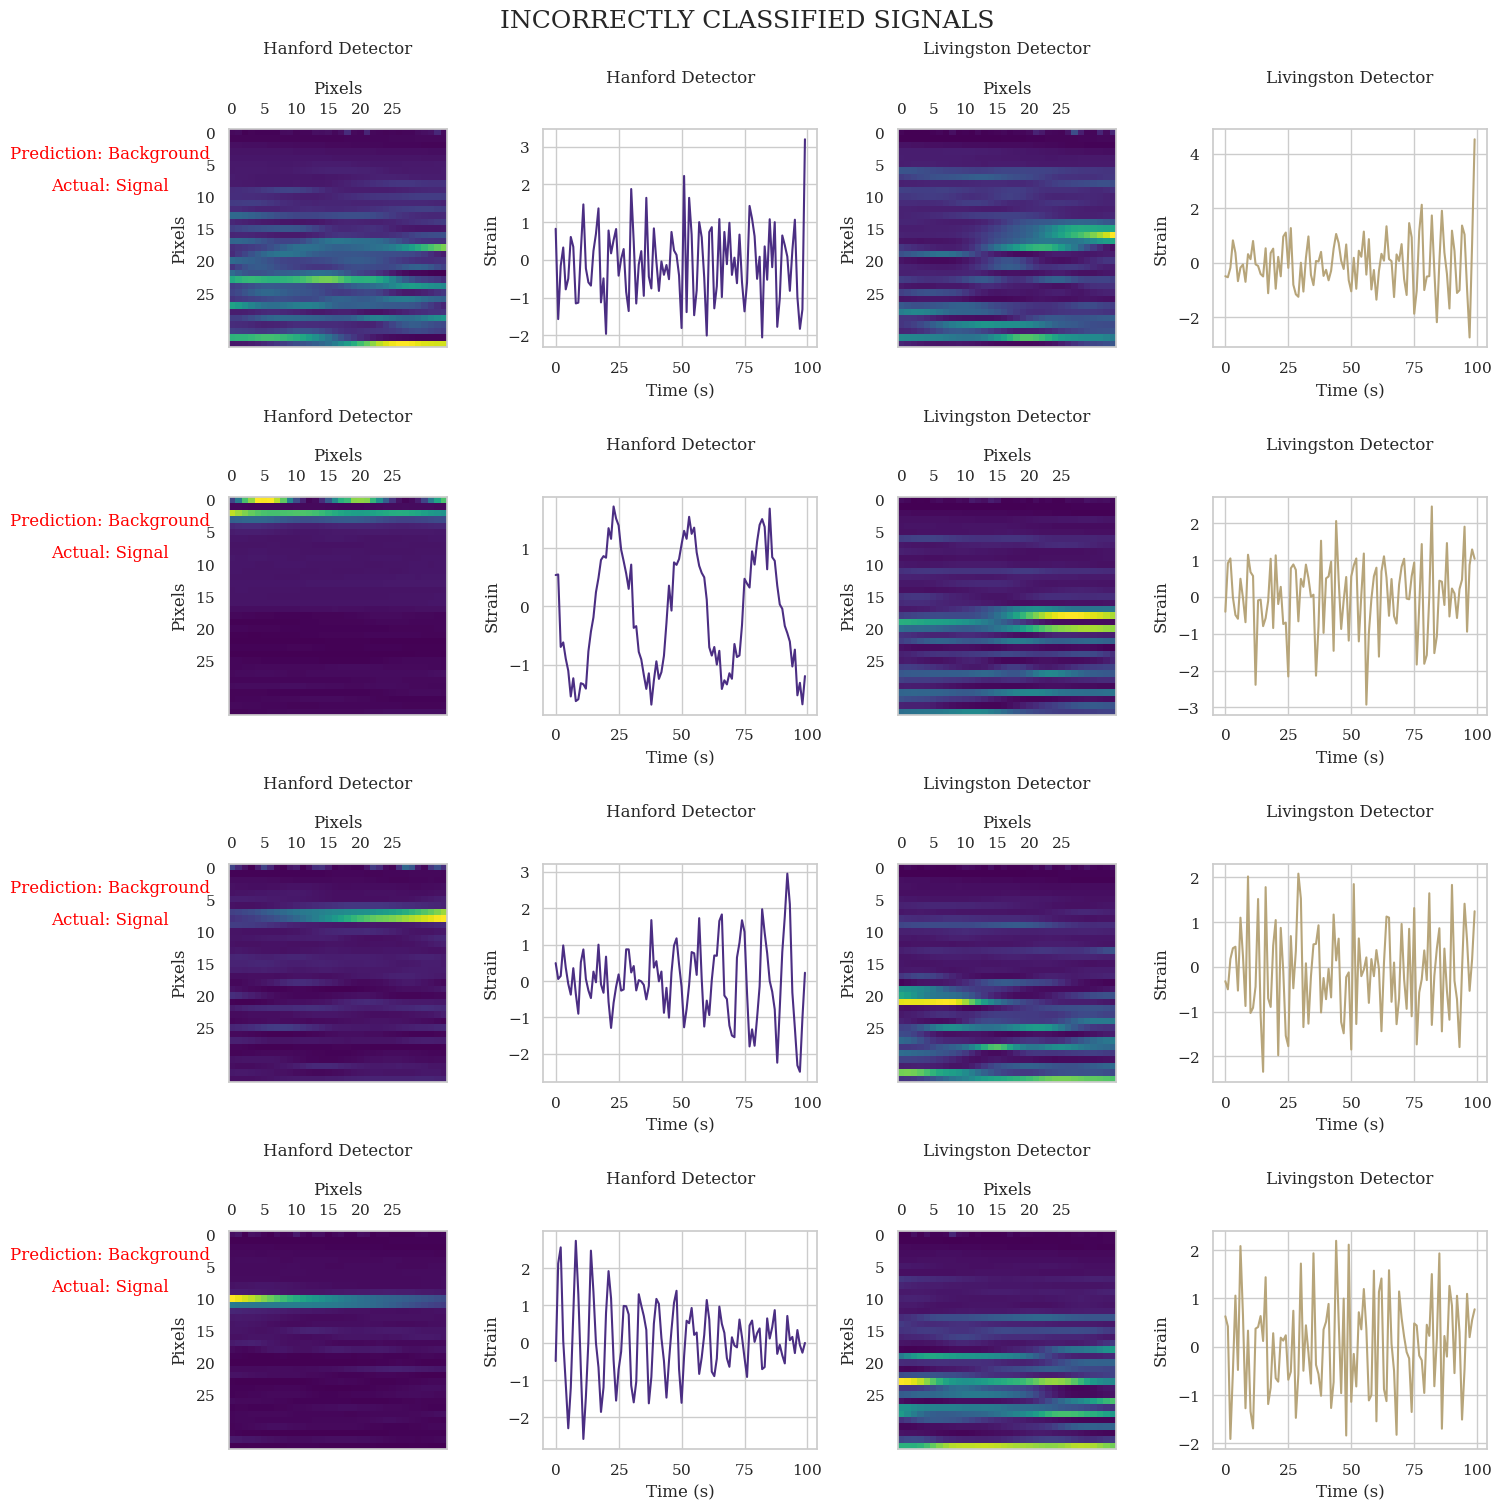

In [ ]:
### -------------Incorrect model predictions------------- ###

# Let's show some of our signals that have been classified incorrectly.
incorrect_index = np.array(np.where(correct == 0))          # Finds the index of the incorrect predictions
resized_testing_inputs = np.reshape(testing_inputs.cpu()
                                    .numpy(), (len(testing_inputs),2,34,34)) # Reshapes the testing inputs to (21908,2,34,34), moves to CPU 
                                                            # and converts to numpy                                                       
pred_test = target_pred_test.cpu().numpy()                  # Moves model testing outputs to CPU and converts to numpy

x = np.arange(0,4096,1)
rand_inc_idx_list = []

plt.figure(figsize = (15, 15), layout="constrained")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
np.random.seed(1)

for i in range(4):
    # Choose random index for an image from our incorrectly classified images to analyze.
    rand_idx = np.random.choice(incorrect_index[0,:])
    rand_inc_idx_list.append(rand_idx.item())
    
    plt.subplot(4,4,i*4 + 1)
    plt.imshow(resized_testing_inputs[rand_idx,0], cmap = 'viridis')
    plt.title('Detector 1\n\nPixels')
    plt.ylabel("Pixels")
    plt.grid(None)
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.yticks([0, 5, 10, 15, 20, 25])
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

    # Adds text to subplots and prints out the incorrect prediction of the model
    plt.text(-19, 4, "Prediction: {}".format(list(anomaly_class.keys())
                                                [list(anomaly_class.values()).index(np.argmax(pred_test[rand_idx][:]))])
                                                , ha='center', color='red')    
    # Adds text to subplots and prints out the correct target item
    plt.text(-19, 9, "Actual: {}".format(list(anomaly_class.keys())
                                             [list(anomaly_class.values()).index(y_val[rand_idx])])
                                             , ha='center', color='red')

    plt.subplot(4,4,i*4 + 2)  
    plt.plot(x,x_val_data[rand_idx,:,0], color="#4b2e83")
    plt.title('Detector 1\n\n')
    plt.xlabel("Time (s)")
    plt.ylabel("Strain")

    plt.subplot(4,4,i*4 + 3)  
    plt.imshow(resized_testing_inputs[rand_idx,1], cmap = 'viridis')
    plt.title('Detector 2\n\nPixels')
    plt.ylabel("Pixels")
    plt.grid(None)
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.yticks([0, 5, 10, 15, 20, 25])
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

    plt.subplot(4,4,i*4 + 4)  
    plt.plot(x,x_val_data[rand_idx,:,1], color="#b7a57a")
    plt.title('Detector 2\n\n')
    plt.xlabel("Time (s)")
    plt.ylabel("Strain")

plt.suptitle("INCORRECTLY CLASSIFIED SIGNALS", fontsize= 18)

# plt.savefig("Incorrect_results.png")
plt.show()

#### Correct Predictions

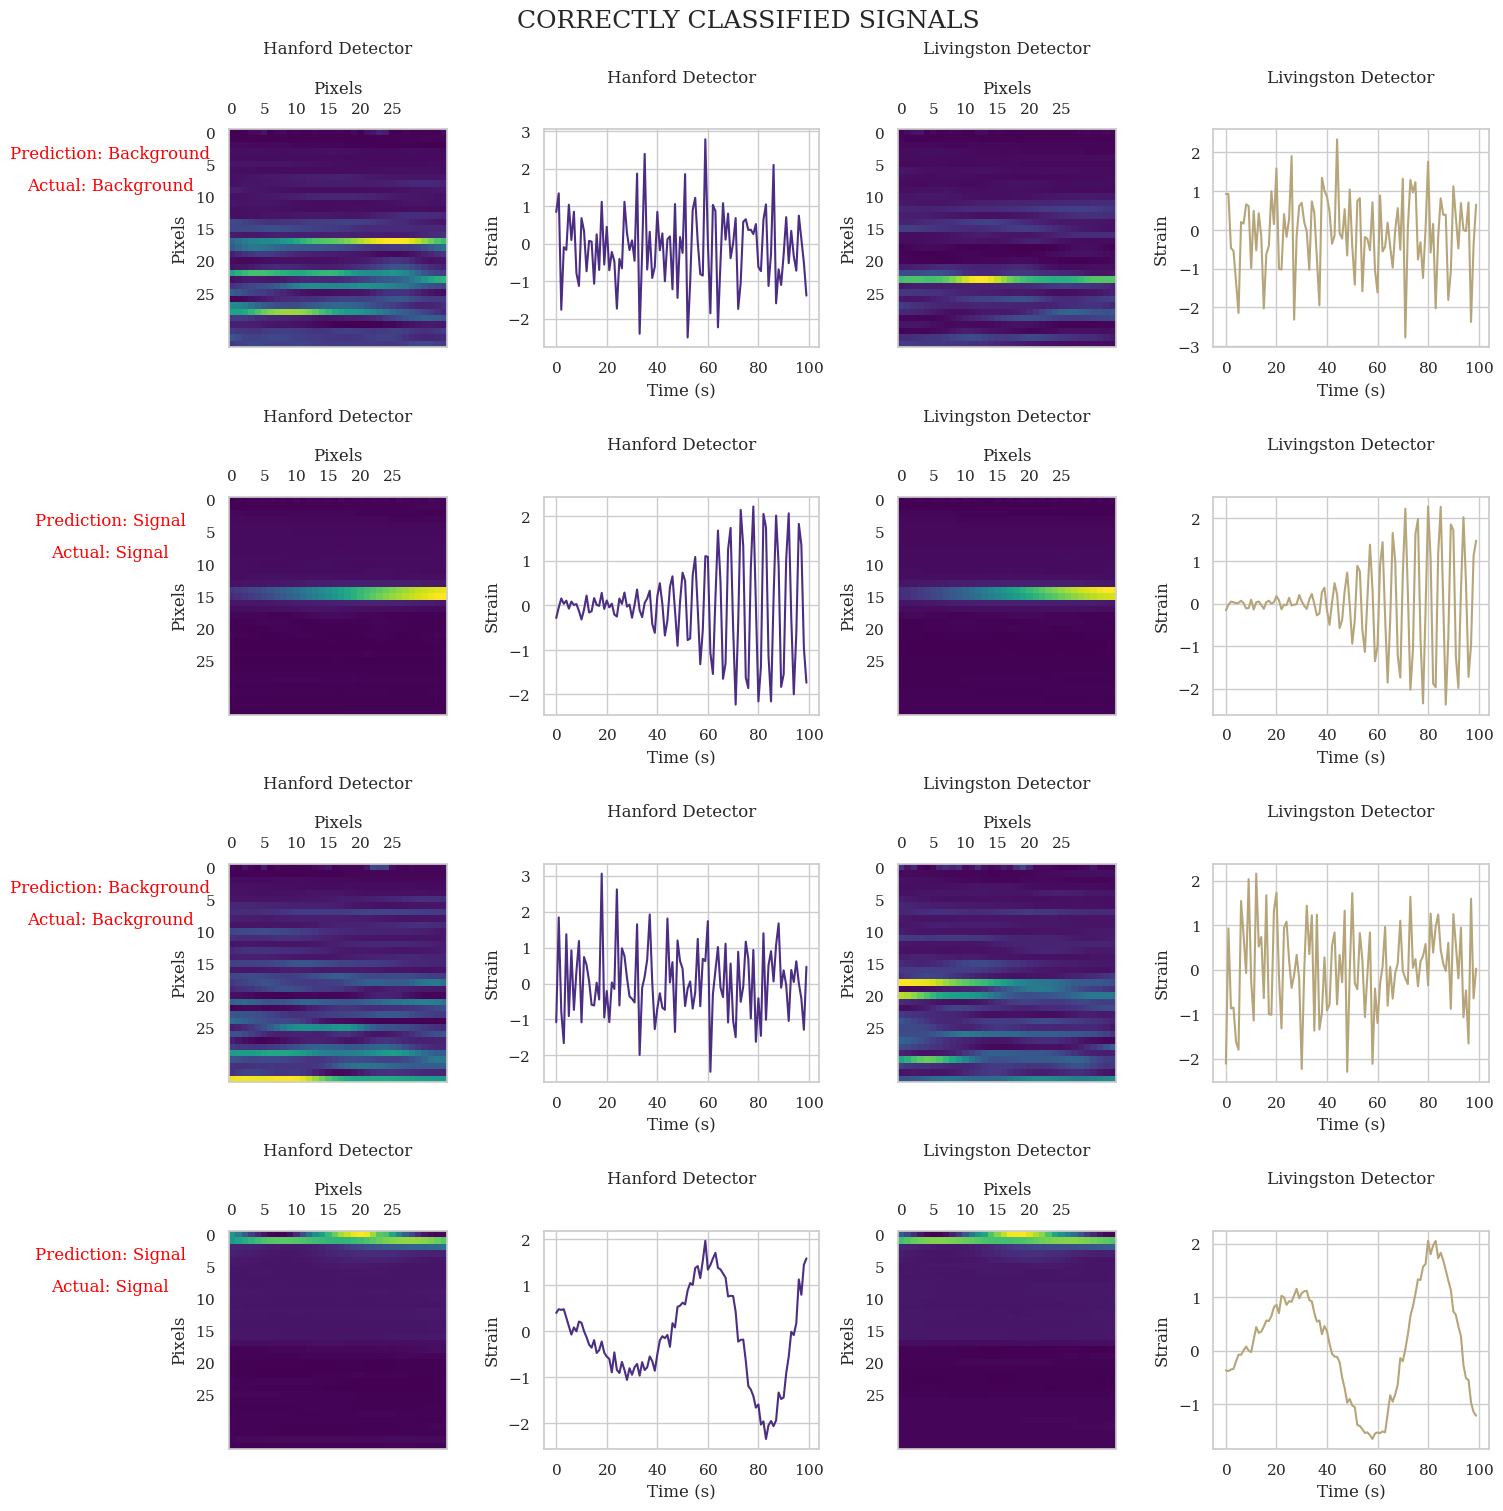

In [ ]:
### -------------Correct model predictions------------- ###

# Now, let's show some of our signals that have been classified correctly.
correct_index = np.array(np.where(correct == 1))          # Finds the index of the incorrect predictions
resized_testing_inputs = np.reshape(testing_inputs.cpu()
                                    .numpy(), (len(testing_inputs),2,34,34)) # Reshapes the testing inputs to (21908,2,34,34), moves to CPU 
                                                            # and converts to numpy                                                       
pred_test = target_pred_test.cpu().numpy()                  # Moves model testing outputs to CPU and converts to numpy

x = np.arange(0,4096,1)
rand_cor_idx_list = []

plt.figure(figsize = (15, 15), layout="constrained")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
np.random.seed(1)

for i in range(4):
    # Choose random index for an image from our correctly classified images to analyze.
    rand_idx = np.random.choice(correct_index[0,:])
    rand_cor_idx_list.append(rand_idx.item())
    
    plt.subplot(4,4,i*4 + 1)   
    plt.imshow(resized_testing_inputs[rand_idx,0], cmap = 'viridis')
    plt.title('Detector 1\n\nPixels')
    plt.ylabel("Pixels")
    plt.grid(None)
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.yticks([0, 5, 10, 15, 20, 25])
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

    # Adds text to subplots and prints out the incorrect prediction of the model
    plt.text(-19, 4, "Prediction: {}".format(list(anomaly_class.keys())
                                                [list(anomaly_class.values()).index(np.argmax(pred_test[rand_idx][:]))])
                                                , ha='center', color='red')    
    # Adds text to subplots and prints out the correct target item
    plt.text(-19, 9, "Actual: {}".format(list(anomaly_class.keys())
                                             [list(anomaly_class.values()).index(y_val[rand_idx])])
                                             , ha='center', color='red')

    plt.subplot(4,4,i*4 + 2)  
    plt.plot(x,x_val_data[rand_idx,:,0], color="#4b2e83")
    plt.title('Detector 1\n\n')
    plt.xlabel("Time (s)")
    plt.ylabel("Strain")

    plt.subplot(4,4,i*4 + 3)  
    plt.imshow(resized_testing_inputs[rand_idx,1], cmap = 'viridis')
    plt.title('Detector 2\n\nPixels')
    plt.ylabel("Pixels")
    plt.grid(None)
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.yticks([0, 5, 10, 15, 20, 25])
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)

    plt.subplot(4,4,i*4 + 4)  
    plt.plot(x,x_val_data[rand_idx,:,1], color="#b7a57a")
    plt.title('Detector 2\n\n')
    plt.xlabel("Time (s)")
    plt.ylabel("Strain")

plt.suptitle("CORRECTLY CLASSIFIED SIGNALS", fontsize= 18)

# plt.savefig("Correct_results.png")
plt.show()

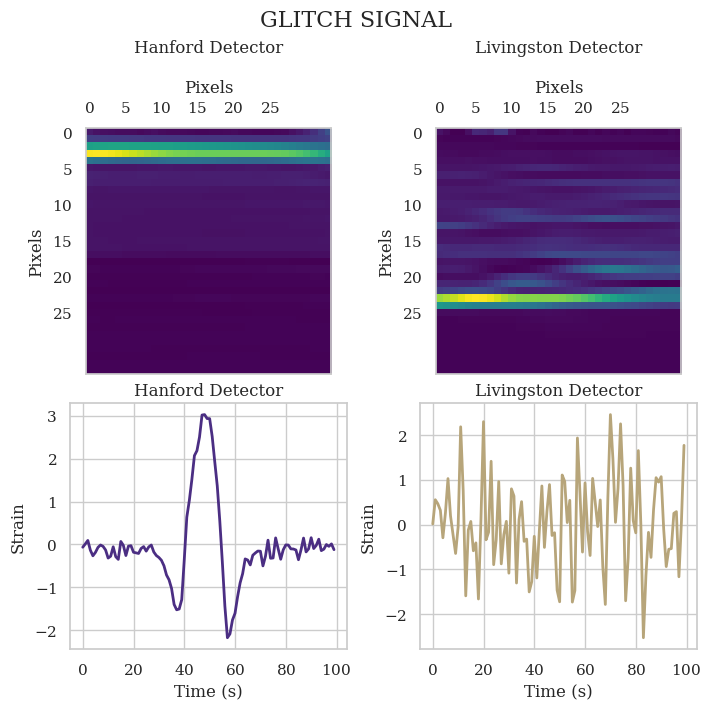

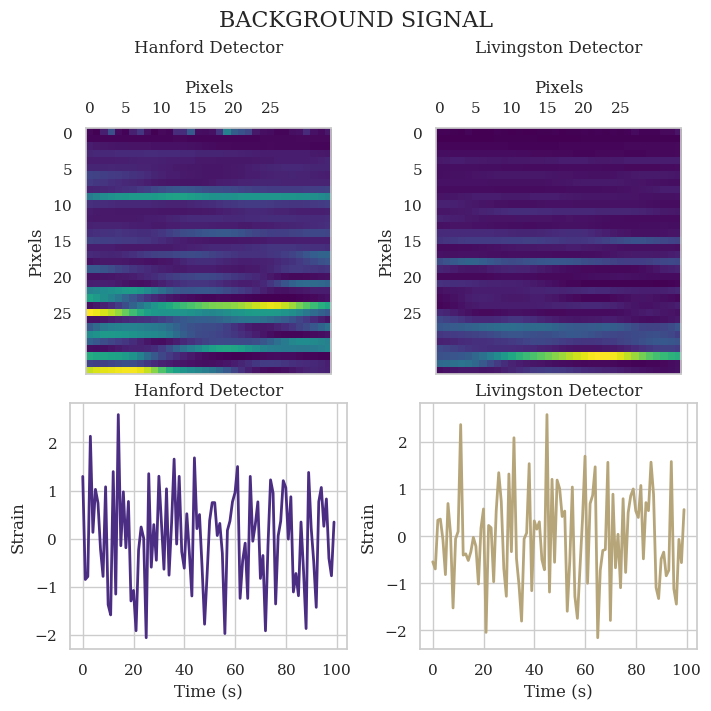

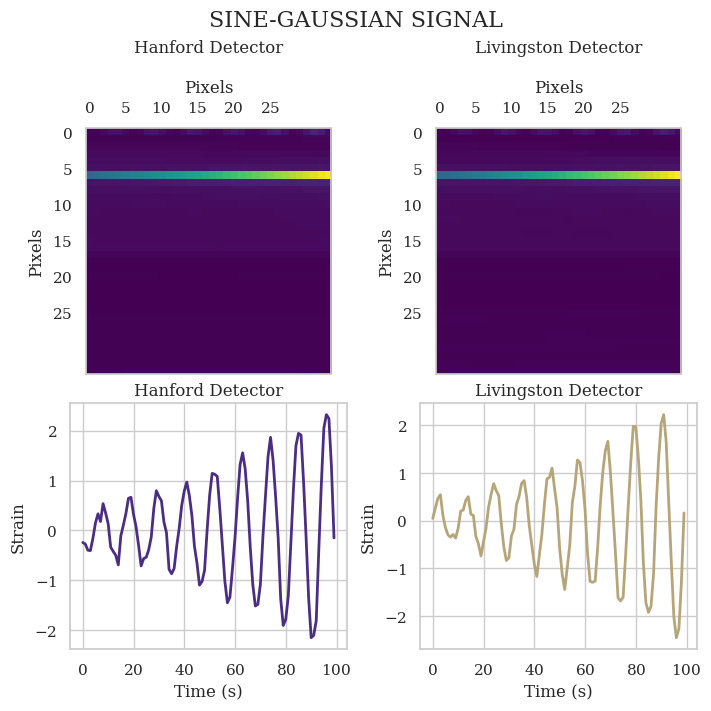

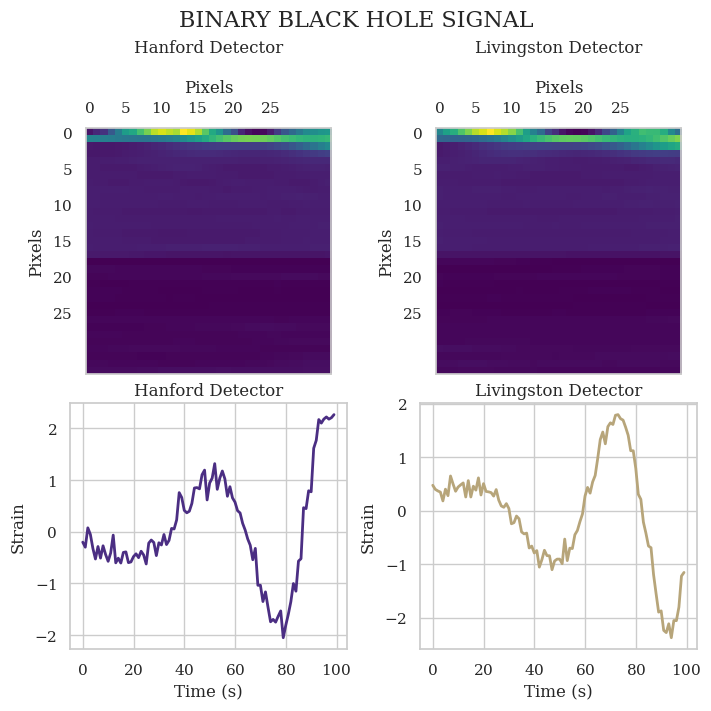

In [ ]:
### -------------Data comparison plots------------- ###

# Comparison plots of the 4 types of signals with their corresponding GASF images

list_data_idx = [7579, 239, 14245, 17911]
list_signal = ["GLITCH SIGNAL", "BACKGROUND SIGNAL", "SINE-GAUSSIAN SIGNAL", "BINARY BLACK HOLE SIGNAL"]
i = 0
for data_idx in list_data_idx:

    line_width = 2
    plt.figure(figsize = (7, 7), layout="constrained")
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.sans-serif"] = "Open Sans"

    plt.subplot(2,2,1)   
    plt.imshow(resized_testing_inputs[data_idx,0], cmap = 'viridis')
    plt.title('Detector 1\n\nPixels')

    plt.grid(None)
    plt.ylabel("Pixels")
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.yticks([0, 5, 10, 15, 20, 25])
    plt.tick_params(axis='both', bottom=False, top=False, labelbottom=False, labeltop=True)


    plt.subplot(2, 2, 2)  
    plt.imshow(resized_testing_inputs[data_idx,1], cmap = 'viridis')
    plt.title('Detector 2\n\nPixels')
    plt.grid(None)
    plt.ylabel("Pixels")
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.yticks([0, 5, 10, 15, 20, 25])
    plt.tick_params(axis='both', bottom=False, top=False, labelbottom=False, labeltop=True)


    plt.subplot(2,2,3)  
    plt.plot(x,x_val_data[data_idx,:,0], color="#4b2e83", linewidth = line_width)
    plt.title('Detector 1')
    plt.xlabel("Time (s)")
    plt.ylabel("Strain")


    plt.subplot(2,2,4)  
    plt.plot(x,x_val_data[data_idx,:,1], color="#b7a57a", linewidth = line_width)
    plt.title('Detector 2')
    plt.xlabel("Time (s)")
    plt.ylabel("Strain")
    plt.suptitle(list_signal[i], fontsize= 16)

    i = i + 1
    # plt.savefig("GLITCH.png")
    plt.show()

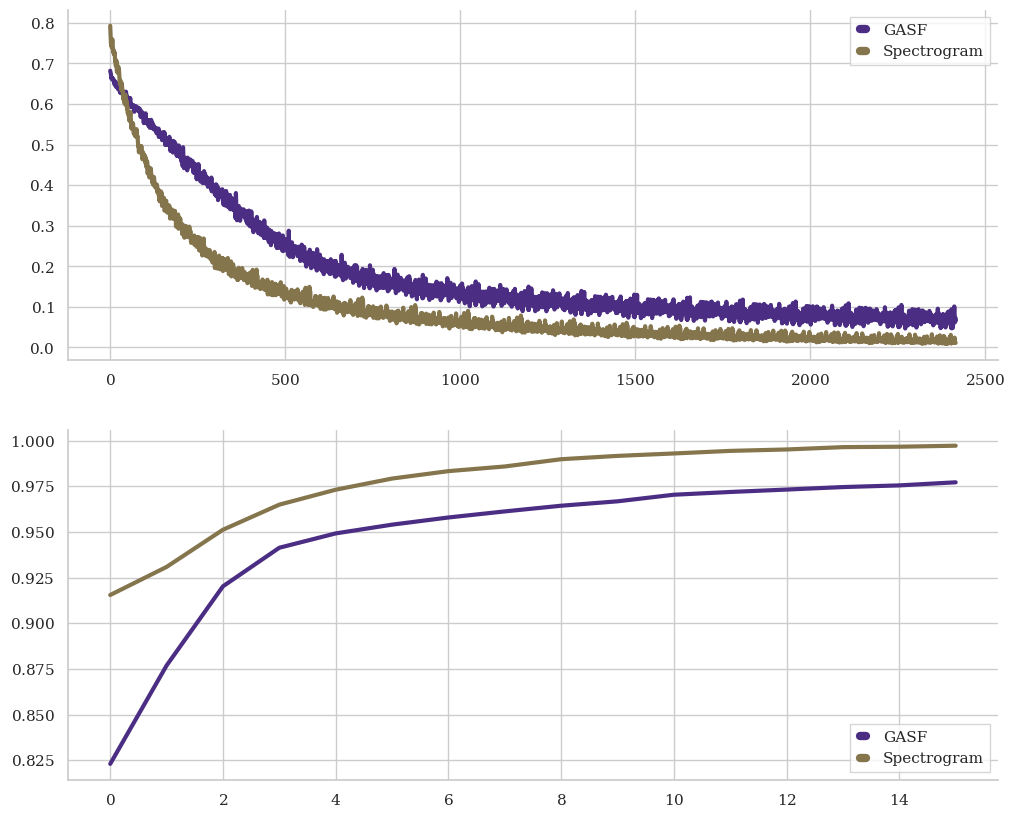

In [ ]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list_gasf, linewidth = 3, color="#4b2e83", label = 'GASF')
plt.plot(train_loss_list_spec, linewidth = 3, color="#85754d", label = 'Spectrogram')
# plt.ylabel("Training loss")
# plt.xlabel("Iterations")
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_gasf, linewidth = 3, color = "#4b2e83", label = 'GASF')
plt.plot(validation_accuracy_list_spec, linewidth = 3, color = "#85754d", label = 'Spectrogram')
# plt.ylabel("Validation Accuracy")
# plt.xlabel("Epochs")
# plt.suptitle("TRAINING LOSS AND VALIDATION ACCURACY")
plt.legend(loc = 'lower right')
sns.despine()

# plt.savefig("trainLoss_valAcc.png")